In [414]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector

# Load the data

In [415]:
df = pd.read_csv("data/diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Get some info from the data

In [416]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [417]:
df.shape

(101766, 50)

# Look at the hist from the numerical variables

array([[<AxesSubplot:title={'center':'encounter_id'}>,
        <AxesSubplot:title={'center':'patient_nbr'}>,
        <AxesSubplot:title={'center':'admission_type_id'}>,
        <AxesSubplot:title={'center':'discharge_disposition_id'}>],
       [<AxesSubplot:title={'center':'admission_source_id'}>,
        <AxesSubplot:title={'center':'time_in_hospital'}>,
        <AxesSubplot:title={'center':'num_lab_procedures'}>,
        <AxesSubplot:title={'center':'num_procedures'}>],
       [<AxesSubplot:title={'center':'num_medications'}>,
        <AxesSubplot:title={'center':'number_outpatient'}>,
        <AxesSubplot:title={'center':'number_emergency'}>,
        <AxesSubplot:title={'center':'number_inpatient'}>],
       [<AxesSubplot:title={'center':'number_diagnoses'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

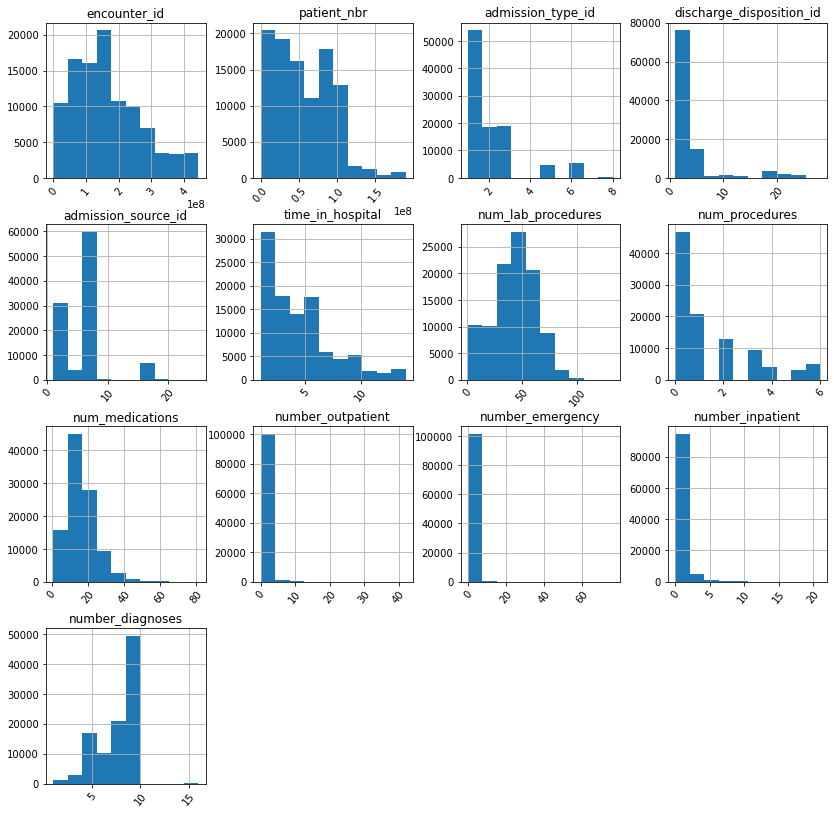

In [418]:
df.hist(figsize=(14,14), xrot=50)

# Get detail imformation from each column so we can replace miss values with imputation and or delated columns or row as appropriate

In [419]:
for i in df.columns[2:]:
    print(i)
    print(df[i].value_counts())
    print("-------------")

race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64
-------------
gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64
-------------
age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64
-------------
weight
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64
-------------
admission_type_id
1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64
-------------
discharge_disposition_id
1     60234
3     13954
6     12902
18  

# First drop the unnecesary columns

First delate the columns that are id of the patients or encounter, so they are usefull for the model, and the columns of weight which is important but the amount of missing values is too much to make it an useful variable, there is 96% of missing values. We also delete the examide medication and citoglipton medication because there is only the no variable, there is not any yes value

In [420]:
l=df["weight"].value_counts(normalize=True)*100
l

?            96.858479
[75-100)      1.312816
[50-75)       0.881434
[100-125)     0.614154
[125-150)     0.142484
[25-50)       0.095317
[0-25)        0.047167
[150-175)     0.034393
[175-200)     0.010809
>200          0.002948
Name: weight, dtype: float64

In [421]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [422]:
df_reduced= df.drop(columns=['encounter_id','patient_nbr','weight','payer_code', 'medical_specialty', 'examide','citoglipton'])
df_reduced.shape
df_reduced.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Binning of the dig 1 diag 2 and dig 3

In [423]:
d1=[]
for i in df_reduced.diag_1:
    if i== any(np.arange(460,519)) or 785:
        d1.append("Circulatory")
    elif i== any(np.arange(520,579)) or 786:
        d1.append("Respiratory")
    elif i== any(np.arange(520, 579)) or 787:
        d1.append("Digestive")
    elif i== any(np.arange(800, 999)):
        d1.append("Injury")
    elif i== any(np.arange(710, 739)):
        d1.append("Musculoskeletal")
    elif i== any(np.arange(580, 629)) or 788:
        d1.append("Genitourinary")
    elif i== any(np.arange(240, 279)):
        d1.append("Endocrine")
    elif i== any(np.arange(250.01, 250.99)):
        d1.append("Diabetes")
    elif i== any(np.arange(140, 239)):
        d1.append("Neoplasms")
    else:
        d1.append("Others")

In [424]:
len(d1)

101766

In [425]:
d2=[]
for i in df_reduced.diag_2:
    if i== any(np.arange(460,519)) or 785:
        d2.append("Circulatory")
    elif i== any(np.arange(520,579)) or 786:
        d2.append("Respiratory")
    elif i== any(np.arange(520, 579)) or 787:
        d2.append("Digestive")
    elif i== any(np.arange(800, 999)):
        d2.append("Injury")
    elif i== any(np.arange(710, 739)):
        d2.append("Musculoskeletal")
    elif i== any(np.arange(580, 629)) or 788:
        d2.append("Genitourinary")
    elif i== any(np.arange(240, 279)):
        d2.append("Endocrine")
    elif i== any(np.arange(250.01, 250.99)):
        d2.append("Diabetes")
    elif i== any(np.arange(140, 239)):
        d2.append("Neoplasms")
    else:
        d2.append("Others")

In [426]:
len(d2)

101766

In [427]:
d3=[]
for i in df_reduced.diag_3:
    if i== any(np.arange(460,519)) or 785:
        d3.append("Circulatory")
    elif i== any(np.arange(520,579)) or 786:
        d3.append("Respiratory")
    elif i== any(np.arange(520, 579)) or 787:
        d3.append("Digestive")
    elif i== any(np.arange(800, 999)):
        d3.append("Injury")
    elif i== any(np.arange(710, 739)):
        d3.append("Musculoskeletal")
    elif i== any(np.arange(580, 629)) or 788:
        d3.append("Genitourinary")
    elif i== any(np.arange(240, 279)):
        d3.append("Endocrine")
    elif i== any(np.arange(250.01, 250.99)):
        d3.append("Diabetes")
    elif i== any(np.arange(140, 239)):
        d3.append("Neoplasms")
    else:
        d3.append("Others")

In [428]:
len(d3)

101766

In [429]:
df_reduced= df_reduced.drop(columns=['diag_1','diag_2','diag_3'])
df_reduced["Diag1"]= d1
df_reduced["Diag2"]= d2
df_reduced["Diag3"]= d3

# We will bin the age variable

In [430]:
Age=[]
for i in df_reduced.age:
    if i== "[70-80)":
        Age.append("Old")
    elif i== "[60-70)":
        Age.append("Old")
    elif i== "[80-90)":
        Age.append("Old")
    elif i== "[90-100)":
        Age.append("Old")
    elif i== "[50-60)":
        Age.append("Midage")
    elif i== "[40-50)":
        Age.append("Midage")
    elif i== "[30-40)":
        Age.append("Yound")
    elif i== "[20-30) ":
        Age.append("Young")
    elif i== "[10-20)":
        Age.append("Pediatrics")
    elif i== "[0-10)":
        Age.append("Pediatrics")
    else:
        Age.append("Old") 
 
 

In [431]:
len(Age)

101766

In [432]:
df_reduced= df_reduced.drop(columns=['age'])
df_reduced["Age"]= Age

# We will replace the missing values from the reminder column

I there is a discrete or categorical values we will replace with the mode, if there is a continous variable we will replace with the mean

In [433]:
df_reduced["race"].replace(to_replace ="?",
                 value ="Caucasian")

# reagenge the id coluns can be useful in a way that all the missing values is place in one place

# admission_type_id
df_reduced.admission_type_id.replace(to_replace = 5,
                                     value = 6)
df_reduced.admission_type_id.replace(to_replace = 8,
                                     value = 6)

# admission_source_id
df_reduced.admission_type_id.replace(to_replace = 9,
                                     value = 17)
df_reduced.admission_type_id.replace(to_replace = 15,
                                     value = 17)
df_reduced.admission_type_id.replace(to_replace = 20,
                                     value = 17)
df_reduced.admission_type_id.replace(to_replace = 21,
                                     value = 17)

0         6
1         1
2         1
3         1
4         1
         ..
101761    1
101762    1
101763    1
101764    2
101765    1
Name: admission_type_id, Length: 101766, dtype: int64

# Next, we remove observations where the discharge disposition is related to hospice or death since these will not add to the possibility of being readmitted.


In [434]:
indexNames = df_reduced[df_reduced['discharge_disposition_id'].isin([11,13,14,19,20,21])].index
df_reduced.drop(indexNames,inplace=True)
df_reduced.shape

(99343, 43)

# Make the result binary

In [435]:
results= df_reduced["readmitted"]
df_reduced= df_reduced.drop(columns=['readmitted'])

In [436]:
response= []
for i in results:
    if i== "NO":
        response.append(0)
    elif i== ">30":
        response.append(0)
    else:
        response.append(1)
    

# Ecode the categorical values

In [437]:
categorical_values= ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide','chlorpropamide',
                     'glimepiride', 'acetohexamide', 'glipizide','glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', 'troglitazone', 'tolazamide', 'insulin',
                      'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                       'metformin-pioglitazone', 'change', 'diabetesMed', 'Diag1', 'Diag2','Diag3', 'Age']



numeric_value= ['admission_type_id', 'discharge_disposition_id','admission_source_id', 'time_in_hospital', 'num_lab_procedures',
                'num_procedures', 'num_medications', 'number_outpatient',
                'number_emergency', 'number_inpatient', 'number_diagnoses',]


# Bulding the model with the pipeline using one hot encoder inside the pipeline

In [438]:
X= df_reduced
y= response
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(df_reduced)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([
    ('cat-preprocessor', categorical_transformer , categorical_columns)])
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",LogisticRegression(max_iter=1000))])
param_grid = {
    'classifier__C': np.arange(0, 1, 0.05),
    'classifier__penalty':["l1", "l2"]
}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=2)
model_grid_search.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat-preprocessor',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                                       handle_unknown='ignore',
                         

# Print the test score parameter

In [440]:
results_LR = pd.DataFrame(model_grid_search.cv_results_['params'])
results_LR['test_score'] = model_grid_search.cv_results_['mean_test_score']
results_LR

,classifier__C,classifier__penalty,test_score
0,0.00,l1,NaN
1,0.00,l2,NaN
2,0.05,l1,NaN
3,0.05,l2,0.886932
4,0.10,l1,NaN
5,0.10,l2,0.886932
6,0.15,l1,NaN
7,0.15,l2,0.886932
8,0.20,l1,NaN
9,0.20,l2,0.886932


# Print the grid stimator

In [441]:
ovr= model_grid_search.best_estimator_
ovr

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat-preprocessor',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['race', 'gender',
                                                   'max_glu_serum', 'A1Cresult',
                                                   'metformin', 'repaglinide',...
                                       

# Using the grid best stimator

In [442]:
ovr.fit(X_train, y_train)
y_hat = ovr.predict(X_test)

# Performance of the modeel

In [443]:
# how did our model perform?
count_misclassified = (y_test != y_hat).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = mt.accuracy_score(y_test, y_hat)
print('Accuracy: {:.2f}'.format(accuracy))
precision = mt.precision_score(y_test, y_hat, average='micro')
print("Precision=", precision)
recal = mt.recall_score(y_test, y_hat, average='micro')
print("Recal=", recal)
fscore = mt.f1_score(y_test, y_hat, average='weighted')
print("fscore=",fscore )
# Confusion matrix
cm= confusion_matrix(y_test, y_hat)
print("Confusion Matrix =", cm)

Misclassified samples: 2328
Accuracy: 0.88
Precision= 0.8828325532236146
Recal= 0.8828325532236146
fscore= 0.827894456888288
Confusion Matrix = [[17541     0]
 [ 2328     0]]


# Plot confusion matrix

Confusion matrix, without normalization
[[17541     0]
 [ 2328     0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


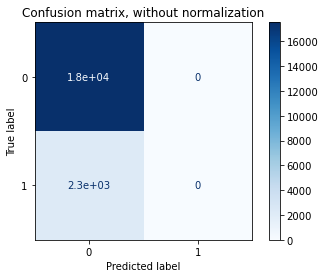

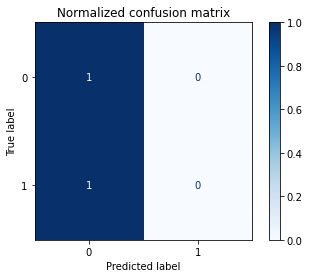

In [444]:

class_names = [0,1]

classifier = ovr.fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


# Plot ROC

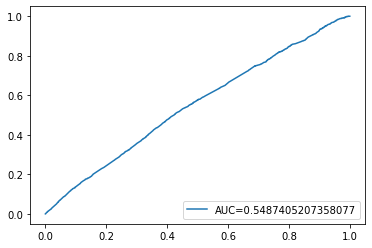

In [445]:
# classifier
classifier = ovr.fit(X_train, y_train)
y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()